In [2]:
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from sklearn.metrics import accuracy_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

# for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = "data/normal-data"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# for binary classification
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2),
    nn.LogSoftmax(dim=1)
)
model = model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        valid_loss = 0
        valid_preds, valid_targets = [], []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                valid_preds.extend(preds.cpu().numpy())
                valid_targets.extend(labels.cpu().numpy())

        valid_acc = accuracy_score(valid_targets, valid_preds)
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Valid Loss: {valid_loss/len(valid_loader):.4f}, "
              f"Valid Accuracy: {valid_acc:.4f}")

train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=5)

model_path = "human_nonhuman_classifier.pth"
torch.save(model.state_dict(), model_path)

model.eval()
test_preds, test_targets = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")


cuda


/home/prottay/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/prottay/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.1799, Valid Loss: 0.0434, Valid Accuracy: 0.9951
Epoch 2/5, Train Loss: 0.0376, Valid Loss: 0.0173, Valid Accuracy: 1.0000
Epoch 3/5, Train Loss: 0.0331, Valid Loss: 0.0132, Valid Accuracy: 1.0000
Epoch 4/5, Train Loss: 0.0242, Valid Loss: 0.0179, Valid Accuracy: 0.9975
Epoch 5/5, Train Loss: 0.0168, Valid Loss: 0.0059, Valid Accuracy: 1.0000
Test Accuracy: 1.0000


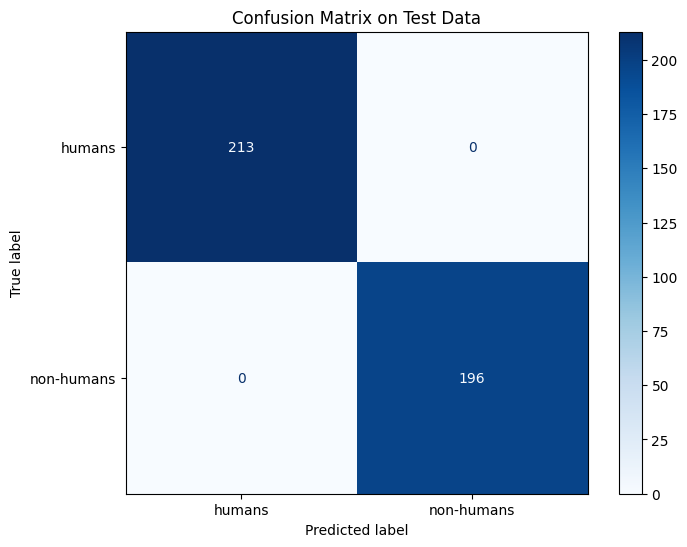

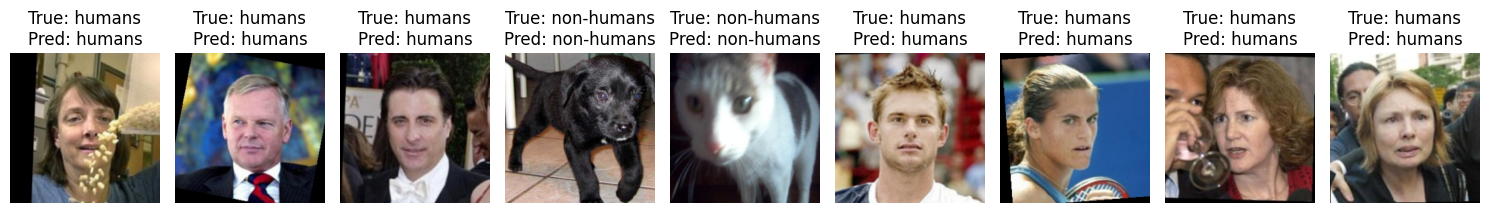

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_targets, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset.classes)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", ax=plt.gca())
plt.title("Confusion Matrix on Test Data")
plt.show("rep2.png")

def plot_predictions(model, data_loader, classes, num_images=5):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 5))
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            
            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    break
                
                img = inputs[i].cpu().permute(1, 2, 0).numpy()
                img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
                img = np.clip(img, 0, 1) 
                
                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(img)
                plt.title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
                plt.axis('off')
                
                images_shown += 1
            
            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.savefig("rep1.png")

# Plot predictions
plot_predictions(model, test_loader, dataset.classes, num_images=9)

In [9]:
from PIL import Image

model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2),
    nn.LogSoftmax(dim=1)
)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

def predict_image(image_path, model, transform, class_names):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.exp(output)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class].item()
    
    return class_names[predicted_class], confidence

class_names = dataset.classes

print(class_names)
image_path = "human.jpg"
predicted_class, confidence = predict_image(image_path, model, transform, class_names)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.4f}")

/tmp/ipykernel_570959/2213542667.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


['humans', 'non-humans']
Predicted Class: humans
Confidence: 0.9771


In [18]:
from PIL import Image, ImageDraw, ImageFilter
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

In [37]:
original_image = Image.open("elon.jpg")

In [ ]:
def cataract(cataract_image):

    cataract_image = cv2.imread(cataract_image)

    cataract_image = cv2.cvtColor(cataract_image, cv2.COLOR_BGR2RGB)
    
    # reduce saturation
    hsv_image = cv2.cvtColor(cataract_image, cv2.COLOR_RGB2HSV)
    hsv_image[..., 1] = hsv_image[..., 1] * 0.9
    desaturated_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
   
    # haze
    haze = np.full_like(desaturated_image, fill_value=220, dtype=np.uint8)
    hazy_image = cv2.addWeighted(desaturated_image, 0.4, haze, 0.3, 0)
    
    # Gaussian blur 
    cataract_image = cv2.GaussianBlur(hazy_image, (15, 15), 0)
    cataract_image = Image.fromarray(cataract_image)
    
    return cataract_image

In [ ]:
def amd(image):
    image = image.convert("RGBA")
    width, height = image.size

    # overlay
    overlay = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    # central blur
    center_x, center_y = width // 2, height // 2
    blur_radius = min(width, height) // 3

    draw.ellipse(
        (center_x - blur_radius, center_y - blur_radius, center_x + blur_radius, center_y + blur_radius),
        fill=(0, 0, 0, 180)
    )

    # peripheral transparency gradient
    for i in range(blur_radius, blur_radius + 50, 5):
        alpha = int(180 * (1 - (i - blur_radius) / 50))
        draw.ellipse(
            (center_x - i, center_y - i, center_x + i, center_y + i),
            outline=(0, 0, 0, alpha),
            width=10
        )

    filtered_image = Image.alpha_composite(image, overlay)
    return filtered_image

In [ ]:
def glucoma(glu_image):
    width, height = glu_image.size
    black_overlay = Image.new('L', (width, height), 0)  # black mask
    draw = ImageDraw.Draw(black_overlay)
    
    # center circle
    vignette_radius = min(width, height) // 3
    center_x, center_y = width // 2, height // 2
    draw.ellipse(
        (center_x - vignette_radius, center_y - vignette_radius, 
         center_x + vignette_radius, center_y + vignette_radius),
        fill=255
    )
    
    # heavy blur
    vignette_mask = black_overlay.filter(ImageFilter.GaussianBlur(50))
    
    glucoma = Image.composite(glu_image.convert("RGB"), Image.new("RGB", glu_image.size, "black"), vignette_mask)
    
    return glucoma

In [ ]:
def refractive(ref_image):
    ref_image = cv2.imread(ref_image)
    
    ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
    
    # random blur
    blur_kernel_size = random.choice(range(15, 30, 2))
    blur_sigma = random.uniform(0.1, 5.0) 
    blurred_image = cv2.GaussianBlur(ref_image, (blur_kernel_size, blur_kernel_size), blur_sigma)
    blurred_image = Image.fromarray(blurred_image)
    
    return blurred_image

In [42]:
def retinopathy(ret_image, max_width=150, max_height=200):
    draw = ImageDraw.Draw(ret_image)
    width, height = ret_image.size

    pouch_count = random.randint(5, 10)
    
    # random positions 
    for _ in range(pouch_count):
        x = random.randint(width // 4, 3 * width // 4) + random.randint(-30, 30) 
        y = random.randint(height // 4, 3 * height // 4) + random.randint(-50, 50) 
        w = random.randint(max_width // 2, max_width)
        h = random.randint(max_height // 2, max_height)

        # distorted shape
        shape = [
            (x - w // 5, y - h // 2),
            (x + w // 5, y + h // 2),
        ]
        draw.ellipse(shape, fill="black", outline=None)
        for _ in range(random.randint(1, 3)): 
            start_angle = random.randint(0, 360)
            end_angle = start_angle + random.randint(30, 180)
            draw.arc(shape, start=start_angle, end=end_angle, fill="black")

    return ret_image

In [43]:
glucoma_create = glucoma(original_image)
glucoma_out = "output/glucoma.png"
glucoma_create.save(glucoma_out)

cataract_create = cataract("elon.jpg")
cataract_out = "output/cataract.png"
cataract_create.save(cataract_out)

refractive_create = refractive("elon.jpg")
refractive_out = "output/refractive.png"
refractive_create.save(refractive_out)

amd_create = amd(original_image)
amd_out = "output/amd.png"
amd_create.save(amd_out)

retinopathy_create = retinopathy(original_image)
retinopathy_out = "output/retinopathy.png"
retinopathy_create.save(retinopathy_out)


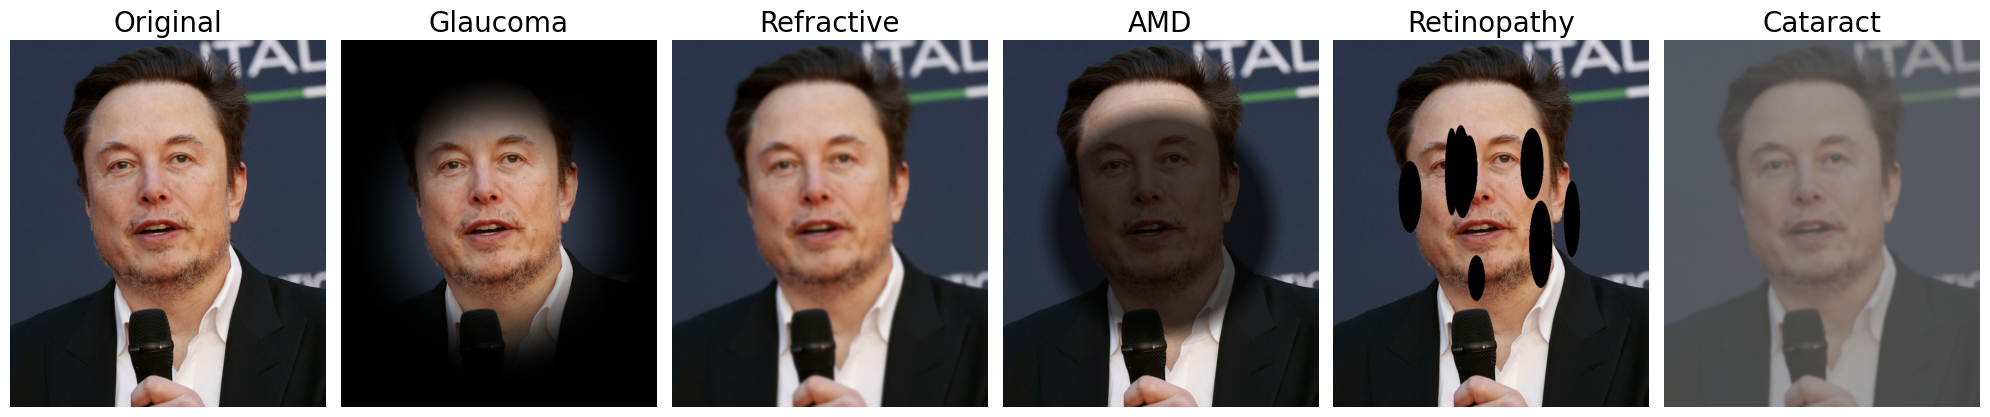

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpi

image_paths = ["elon.jpg", "output/glucoma.png", "output/refractive.png", "output/amd.png", "output/retinopathy.png", "output/cataract.png"]
captions = ['Original', 'Glaucoma', 'Refractive', 'AMD', 'Retinopathy', 'Cataract']

fig, axes = plt.subplots(1, 6, figsize=(20, 5))
for ax, img_path, caption in zip(axes, image_paths, captions):
    img = mpi.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(caption)
    ax.title.set_fontsize(20)

plt.tight_layout()
plt.show()